In [1]:
import gammapy
print(gammapy.__version__)

0.19


In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.estimators import LightCurveEstimator
from gammapy.maps import MapAxis, WcsGeom, Map, MapAxes, WcsNDMap
from gammapy.irf import load_cta_irfs
from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel
)

In [3]:
from gammapy.utils.interpolation import (
    ScaledRegularGridInterpolator,
    interpolation_scale,
)
from astropy.utils import lazyproperty
from gammapy.irf.core import IRF  # possibly inherite from IRF
class EdispInv():
    """
    Class to give the PDF for an event with e_reco = E to come from a true energy E'
    """
    default_interp_kwargs = dict(
        bounds_error=False,
        fill_value=0.0,
    )
    def __init__(self, edisp2d, emin, emax, e_steps=120, interp_kwargs=None):
        """
        edisp2d: gammapy.irf.EnergyDispersion2D
        energy_reco: MapAxis with reconstructed energies
        """
        self._edisp2d = edisp2d
        self.energy_reco = np.geomspace(emin, emax, e_steps) # fine sampled e_reco edges
        self.e_reco =MapAxis.from_edges(self.energy_reco, name="energy", interp="log")
        # keep original axes to loose no information through interpolation
        self.offset=self._edisp2d.axes["offset"]
        self.migra=self._edisp2d.axes["migra"]
        self.e_true=self._edisp2d.axes["energy_true"]
        self.axes = MapAxes([self.offset, self.e_true, self.e_reco])
        kernels = []
        pdfs = []
        for off in self.offset.center:
            kernel=self._edisp2d.to_edisp_kernel(offset=off, 
                                                 energy=self.energy_reco)
            data = kernel.data # probabilities normed along e_reco (axis=1)
            # renorm along e_true
            with np.errstate(invalid='ignore'):
                data /= data.sum(axis=0)
                
            data = np.nan_to_num(data)
            pdf = data / np.diff(self.e_true.edges)[:,np.newaxis]
            kernels.append(data)
            pdfs.append(pdf)
            
#         self.data = NDDataArray(axes=axes, data=np.array(kernels))
#         self.data_pdf = NDDataArray(axes=axes, data=np.array(pdfs))
        
        self.kernels=np.array(kernels)
        self.pdfs = np.array(pdfs)/self.e_true.unit
        
        if interp_kwargs is None:
            interp_kwargs = self.default_interp_kwargs.copy()
        self.interp_kwargs = interp_kwargs
    @lazyproperty   
    def _interpolate(self):
        kwargs = self.interp_kwargs.copy()
        # Allow extrap[olation with in bins
        kwargs["fill_value"] = None
        points = [a.center for a in self.axes]
        points_scale = tuple([a.interp for a in self.axes])
        return ScaledRegularGridInterpolator(
            points,
            self.pdfs,
            points_scale=points_scale,
            **kwargs,
        )
    @staticmethod
    def _mask_out_bounds(invalid):
        return np.any(invalid, axis=0)
    
    def evaluate(self, method=None, **kwargs):
        """Evaluate IRF
        Parameters
        ----------
        **kwargs : dict
            Coordinates at which to evaluate the IRF
        method : str {'linear', 'nearest'}, optional
            Interpolation method
        Returns
        -------
        array : `~astropy.units.Quantity`
            Interpolated values
        """
        # TODO: change to coord dict?
        non_valid_axis = set(kwargs).difference(self.axes.names)
        if non_valid_axis:
            raise ValueError(
                f"Not a valid coordinate axis {non_valid_axis}"
                f" Choose from: {self.axes.names}"
            )

        coords_default = self.axes.get_coord()

        for key, value in kwargs.items():
            coord = kwargs.get(key, value)
            if coord is not None:
                coords_default[key] = u.Quantity(coord, copy=False)
        data = self._interpolate(coords_default.values(), method=method)

        if self.interp_kwargs["fill_value"] is not None:
            idxs = self.axes.coord_to_idx(coords_default, clip=False)
            invalid = np.broadcast_arrays(*[idx == -1 for idx in idxs])
            mask = self._mask_out_bounds(invalid)
            if not data.shape:
                mask = mask.squeeze()
            data[mask] = self.interp_kwargs["fill_value"]
            data[~np.isfinite(data)] = self.interp_kwargs["fill_value"]
        return data
    
    def plot_pdf_vs_Etrue(self, ax=None, e_reco=None, offset=None, **kwargs):
        
        ax = plt.gca() if ax is None else ax

        if offset is None:
            offset = [Angle(1, "deg")]
            
        if e_reco is None:
            e_reco = [1]*u.TeV

        energy_true = self.axes["energy_true"]

        
        
        for o in offset:
            for e in e_reco:
                z = self.evaluate(
                    offset=o,
                    energy_true=energy_true.center,
                    energy=e,
                )
                ax.semilogx(energy_true.center, z,label=f'{e} - {o}', **kwargs)
            
        ax.legend()
        ax.set_xlabel(f'Energy True [{energy_true.unit}]')
        ax.set_ylabel('Probability density')
        return ax

In [4]:
### Generate a data set
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]

No HDU found matching: OBS_ID = 23523, HDU_TYPE = rad_max, HDU_CLASS = None


In [5]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
ebins = np.logspace(-1,2,49)
# e_edges = ebins.copy()[np.where(ebins>=min_energy)[0][0]-3:]
# e_edges[-1] = 84.
energy_axis = MapAxis.from_edges(
    ebins[::2], unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
geom = WcsGeom.create(
    skydir=crab_pos,
    binsz=0.02,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

circle = CircleSkyRegion(
    center=crab_pos, radius=0.3 * u.deg
)
data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [6]:
%%time
maker = MapDatasetMaker(background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max', 'aeff-default'], offset_max='1.5 deg')
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)  

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)

assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
dataset.background.data[~dataset.mask_safe.data] = 0.0

bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models=bkg_model
dataset.background_model.spectral_model.tilt.frozen = False
dataset = maker_fov.run(dataset)
print(
    f"Background norm obs {obs1.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f} \
    (tilt={dataset.background_model.spectral_model.tilt.value:.2f})"
)

Background norm obs 23523: 0.83     (tilt=-0.12)
CPU times: user 4.91 s, sys: 437 ms, total: 5.34 s
Wall time: 6.22 s


In [7]:
### store the events
ev_table=obs1.events.table
ev_table

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float32,float32,float32
5407363825684,123890826.66805482,84.97964,23.89347,10.352011
5407363825695,123890826.69749284,84.54751,21.004095,4.0246882
5407363825831,123890827.23673964,85.39696,19.41868,2.2048872
5407363825970,123890827.79615426,81.93147,20.79867,0.69548655
5407363826067,123890828.26131463,85.98302,21.053099,0.86911184
5407363826095,123890828.41393518,86.97305,21.837437,4.1240892
5407363826128,123890828.52555823,83.40073,19.771587,1.6680022
5407363826168,123890828.6829524,82.25036,19.22003,4.7649446


[158156.19552684 146002.69482856 133849.19413029 116984.29207296
  97593.40219469  75886.36230491  59453.66302243  46168.66481485
  36805.91523224  28533.44774432  22640.73426085  17686.03380324
  14250.66183044  11480.69846992   9517.36934999   7650.4221036
   6155.98566573   4937.58958742   4476.65275941   3725.81949061] 1 / sr


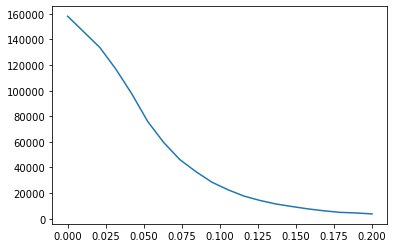

In [8]:
### evaluate and check the psf
test=obs1.psf

rad=np.linspace(0,0.2,20)*u.deg
psf_test=test.evaluate(energy_true=1*u.TeV, offset=1*u.deg, rad=rad)
print(psf_test)
plt.plot(rad,psf_test)

<AxesSubplot:xlabel='Energy True [TeV]', ylabel='Probability density'>

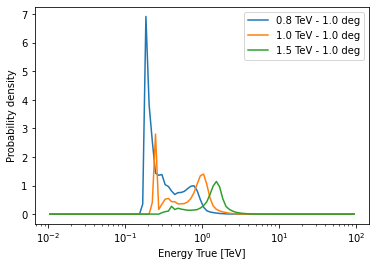

In [9]:
### set up and check inverse edisp
einv = EdispInv(obs1.edisp, 20*u.GeV, 100*u.TeV)

einv.plot_pdf_vs_Etrue(e_reco=[0.8,1,1.5]*u.TeV)

Text(0.5, 1.0, 'e_reco = 0.8 TeV')

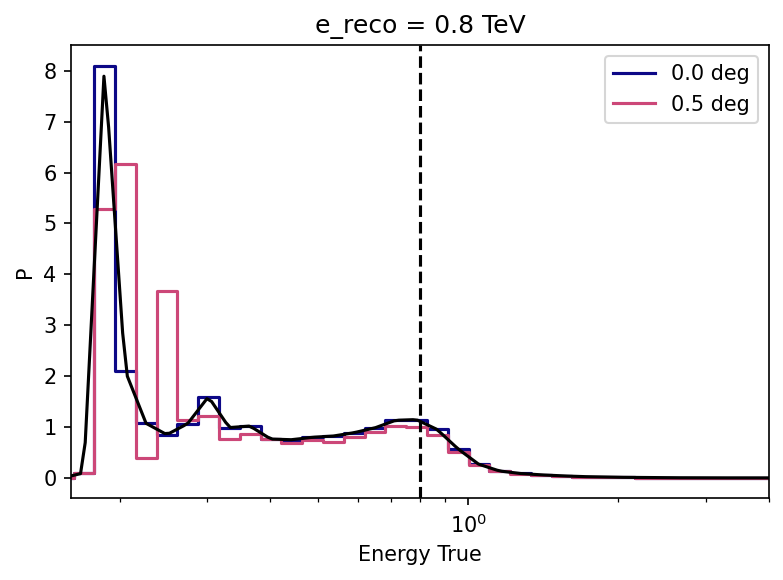

In [14]:
e_reco=.8*u.TeV
plt.figure(dpi=150)
offsets=einv.offset.center[:2]
for i,off in enumerate(offsets):
    plt.semilogx(einv.e_true.center, 
                 einv.evaluate(offset=off, energy=e_reco).flatten(), 
                 color=plt.cm.plasma(i/offsets.size), label=off, ds='steps-mid')
    
plt.xlabel("Energy True")
plt.ylabel("P")

plt.xlim(e_reco.value/5,e_reco.value*5)
plt.legend()
idx=einv.e_reco.coord_to_idx(e_reco)[0]
# plt.plot(einv.e_true.center, einv.kernels[-1,:,idx], ls='--', ds='steps-mid')
e_true_fine = np.geomspace(e_reco/5, e_reco*5,150)
plt.semilogx(e_true_fine, 
                 einv.evaluate(offset=0*u.deg, energy=e_reco, energy_true=e_true_fine).flatten(), 
                 color='k')
# plt.semilogx(einv.e_true.center, 
#                  einv.evaluate(offset=2.3*u.deg, energy=e_reco).flat, 
#                  color='k', ds='steps-mid')
plt.axvline(e_reco.value, c='k', ls='--')
plt.title(f'e_reco = {e_reco}')

In [15]:
### set up true geometry for integration
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos = obs1.pointing_radec
# choose energy binning
# ebins = np.geomspace(0.6,100,25)
ebins_true = np.logspace(-1,2,49)

energy_axis_true = MapAxis.from_edges(
    ebins_true, unit="TeV", name="energy_true", interp="log"  
)
# migra_axis = MapAxis.from_bounds(
#     0.5, 2, nbin=150, node_type="edges", name="migra"
# )
geom_true = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.02,
    width=(3.5, 3.5),
    frame="icrs",  # same frame as events
    proj="CAR",
    axes=[energy_axis_true],
)


In [16]:
model_gauss = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )


In [17]:
### integrate the model on the true geometry
integrated_map=model_gauss.integrate_geom(geom_true)
bin_volume=geom_true.bin_volume()

In [18]:
offsets = geom_true.separation(obs_pos)  # offsets of the true geometry pixels
coords=geom_true.get_coord(sparse=True)  # coordinates of the true geometry
livetime = obs1.observation_live_time_duration

In [19]:
### get the exposure on the true geometry
exposure_data=obs1.aeff.evaluate(energy_true=coords['energy_true'], offset=offsets)
exposure_data *= livetime

In [20]:
### mask all events which are outside the mask safe
event_coords = obs1.events.map_coord(dataset.mask_safe.geom)
mask_safe_events = dataset.mask_safe.get_by_coord(event_coords).astype(bool)

In [21]:
### mask all events which are outside the 99% tail of the psf
psf = obs1.psf
offsets_event_pointing = obs1.events.radec.separation(obs1.events.pointing_radec)
c_radii=psf.containment_radius(fraction=0.99, energy_true=event_coords['energy'], offset = offsets_event_pointing)

mask_offset = obs1.events.radec.separation(model_gauss.spatial_model.position) <= c_radii 

In [22]:
### combine the masks
mask_combined = mask_safe_events & mask_offset
mask_combined.sum()

323

In [23]:
%%time
L=0
### loop through all events and calculate its probability to belong to the model
constant=exposure_data * integrated_map.quantity*geom_true.bin_volume() # same for each event
for i,row in enumerate(obs1.events.table[mask_combined]):
    energy = row['ENERGY'] * obs1.events.table['ENERGY'].unit
    event_pos = obs1.events.radec[mask_combined][i]
    event_offsets = geom_true.separation(event_pos)
    edisp_factors = einv.evaluate(energy=energy, offset=offsets, energy_true=coords['energy_true'])
    psf_factors = psf.evaluate(offset=offsets, energy_true=coords['energy_true'],rad=event_offsets)
    integral = np.sum(constant*edisp_factors*psf_factors)
    if integral <= 0:
        print(i, row)
        # event doesn't contribute
        continue
    L += np.log(integral)
    if i%50 == 49:
        print(f"finished {i} / {mask_combined.sum()}")
print(L) # actually we still need to subtract npred_tot

finished 49 / 323
finished 99 / 323
finished 149 / 323
finished 199 / 323
finished 249 / 323
finished 299 / 323
-1819.7168478581984
CPU times: user 5min 58s, sys: 7.89 s, total: 6min 6s
Wall time: 6min 6s
